In [346]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
%matplotlib inline

In [347]:
from sklearn.model_selection import train_test_split

In [348]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [349]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [350]:
# data preparation
url = "https://raw.githubusercontent.com/muhammadisa/threatmsgdetect/main/message-dataset.csv"
messages = pd.read_csv(url)
messages[:10]

,message,label
0,"Woy ngentot bayar gak, gw sebar foto2 lu",threat
1,oi jamet bayar gak lo skrg?!,threat
2,hati hati anda saya gak segan mencelakai anda,threat
3,kirim uang 100 juta jika tidak bom akan dikirim ke rumah kamu,threat
4,Liat aja klo gak bayar bakal terjadi hal buruk sama keluarga lu,threat
5,Woy ngentot,threat
6,"Pokoknya lu harus tanggung jawab, kalo engga gua laporin lu ke polisi",threat
7,"ANAK ANJING, BAYAR UTANG LU SEKARANG ATAU MAU GUE LAPORIN POLISI PENJARA HUKUM MATI??!",threat
8,"ANAK ANJING, BAYAR UTANG LU SEKARANG ATAU MAU GUE LAPORIN POLISI PENJARA HUKUM MATI??!",threat
9,"Pokoknya lu harus tanggung jawab, kalo engga gua laporin lu ke polisi",threat


In [351]:
# describe detail of data show you how much unique, top, req, count
messages.describe()

,message,label
count,178,178
unique,54,2
top,w gak bisa lama lama ya w ada kerjaan apa enggak u suruh si onoh aja,threat
freq,8,146


In [352]:
# finding duplicated data
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

                                                                                   message  \
8   ANAK ANJING, BAYAR UTANG LU SEKARANG ATAU MAU GUE LAPORIN POLISI PENJARA HUKUM MATI??!   
9                    Pokoknya lu harus tanggung jawab, kalo engga gua laporin lu ke polisi   
12                                                                                  Jancok   
16                   Pokoknya lu harus tanggung jawab, kalo engga gua laporin lu ke polisi   
18                                                                            GW GOLOK LOE   

     label  
8   threat  
9   threat  
12  threat  
16  threat  
18  threat  


In [353]:
messages.groupby('label').describe().T

label                   netral  \
message count               32   
        unique               6   
        top     cuy gak mabar?   
        freq                 8   

label                                                                          threat  
message count                                                                     146  
        unique                                                                     48  
        top     Pokoknya lu harus tanggung jawab, kalo engga gua laporin lu ke polisi  
        freq                                                                        6

In [354]:
# Get all the ham and spam emails
threat_msg = messages[messages.label =='threat']
netral_msg = messages[messages.label=='netral']

# Create numpy list to visualize using wordcloud
threat_msg_text = " ".join(threat_msg.message.to_numpy().tolist())
netral_msg_text = " ".join(netral_msg.message.to_numpy().tolist())

In [355]:
factoryStopword = StopWordRemoverFactory()
stopwords = factoryStopword.get_stop_words()

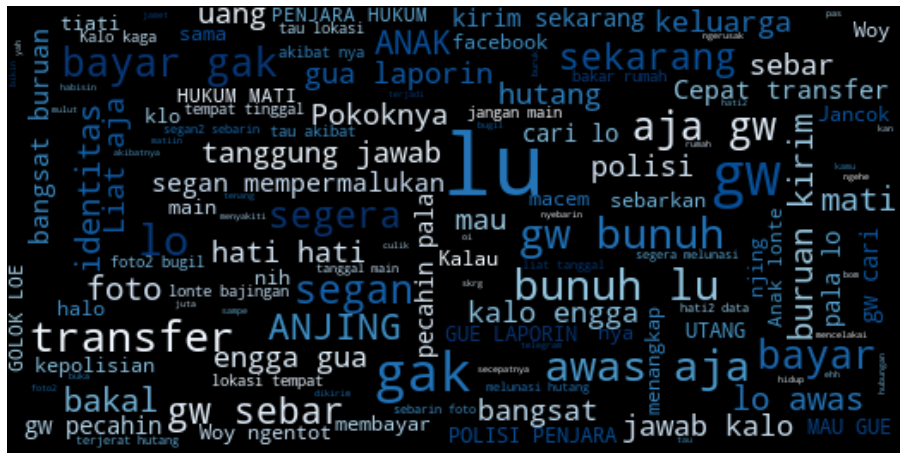

In [356]:
# wordcloud of threat messages
threat_msg_cloud = WordCloud(width =520, height =260, stopwords=stopwords, max_font_size=50, background_color ="black", colormap='Blues').generate(threat_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(threat_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

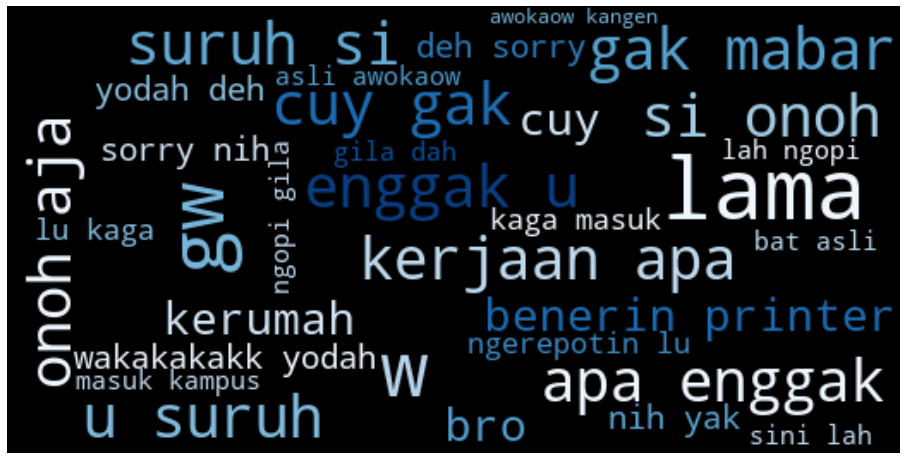

In [357]:
# wordcloud of netral messages
netral_msg_cloud = WordCloud(width =520, height =260, stopwords=stopwords,max_font_size=50, background_color ="black", colormap='Blues').generate(netral_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(netral_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

/home/stoic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


456.25

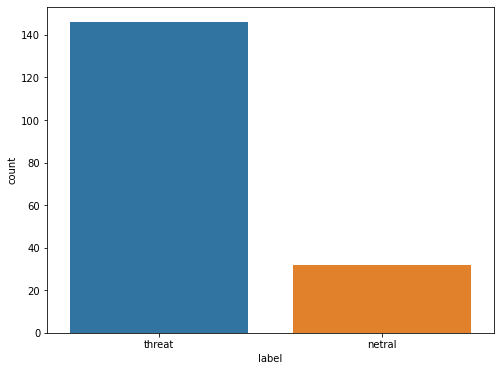

In [358]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of threat messages
(len(threat_msg)/len(netral_msg))*100 # 15.48%

In [359]:
# netral_msg_df = netral_msg
# threat_msg_df = threat_msg
# print(threat_msg_df.shape, netral_msg_df.shape)

netral_msg_df = netral_msg.sample(n = len(threat_msg), random_state = 44, replace=True)
threat_msg_df = threat_msg
print(threat_msg_df.shape, netral_msg_df.shape)

(146, 2) (146, 2)


/home/stoic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Message types')

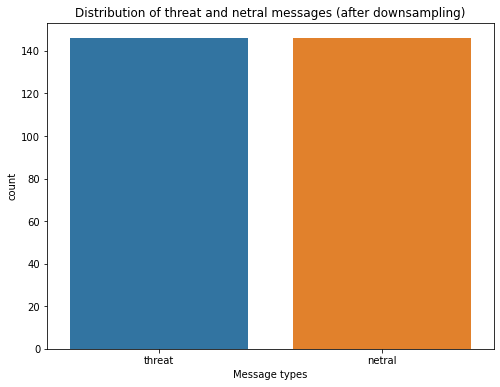

In [360]:
# Create a dataframe with these threat and netral msg
msg_df = threat_msg_df.append(netral_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of threat and netral messages (after downsampling)')
plt.xlabel('Message types')

In [361]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
netral,40.219178
threat,42.369863


In [362]:
# Map netral label as 0 and threat as 1
msg_df['msg_type']= msg_df['label'].map({'netral': 0, 'threat': 1})
msg_label = msg_df['msg_type'].values

In [363]:
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.3, random_state=10)

In [364]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 150

In [365]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [366]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'gw': 2,
 'lu': 3,
 'gak': 4,
 'lama': 5,
 'ya': 6,
 'w': 7,
 'cuy': 8,
 'aja': 9,
 'anda': 10,
 'nanti': 11,
 'lo': 12,
 'ada': 13,
 'mabar': 14,
 'bisa': 15,
 'kerjaan': 16,
 'apa': 17,
 'enggak': 18,
 'u': 19,
 'suruh': 20,
 'si': 21,
 'onoh': 22,
 'bayar': 23,
 'bro': 24,
 'kerumah': 25,
 'benerin': 26,
 'printer': 27,
 'nih': 28,
 'kaga': 29,
 'akan': 30,
 'wakakakakk': 31,
 'yodah': 32,
 'deh': 33,
 'sorry': 34,
 'yak': 35,
 'ngerepotin': 36,
 'bunuh': 37,
 'masuk': 38,
 'kampus': 39,
 'transfer': 40,
 'sekarang': 41,
 'atau': 42,
 'kami': 43,
 'kalo': 44,
 'tidak': 45,
 'sini': 46,
 'lah': 47,
 'ngopi': 48,
 'gila': 49,
 'dah': 50,
 'bat': 51,
 'asli': 52,
 'awokaow': 53,
 'kangen': 54,
 'segan': 55,
 'main': 56,
 'sebar': 57,
 'hutang': 58,
 'kirim': 59,
 'saya': 60,
 'mati': 61,
 'harus': 62,
 'laporin': 63,
 'polisi': 64,
 'awas': 65,
 'jika': 66,
 'segera': 67,
 'anak': 68,
 'bangsat': 69,
 'liat': 70,
 'hati': 71,
 'foto': 72,
 'tau': 73,
 'identitas': 74,
 'g

In [367]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 170 unique tokens in training data. 


In [368]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences(training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                               
padding = padding_type, truncating = trunc_type)

In [369]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (204, 50)
Shape of testing tensor:  (88, 50)


In [370]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(3, 11)

In [371]:
# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [372]:
print(training_padded[0])

[ 8  4 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


In [373]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [374]:
#Dense model architecture
# model = Sequential()
# model.add(LSTM(32, return_sequences=True, activation = 'sigmoid', input_shape=(train_msg.shape[1], train_msg.shape[2])))
# # model.add(Dropout(0.2))
# # model.add(BatchNormalization())
# model.add(LSTM(units = 64, return_sequences=False,))
# model.add(Dense(y_train.shape[1]))
# model.compile(optimizer = 'adam', loss = 'mse')

model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [375]:
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d_9 ( (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 24)                408       
_________________________________________________________________
dropout_9 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [376]:
model.compile(loss='mse',optimizer='adam' ,metrics=['accuracy'])

In [377]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
7/7 - 5s - loss: 0.2495 - accuracy: 0.5000 - val_loss: 0.2498 - val_accuracy: 0.4773
Epoch 2/30
7/7 - 1s - loss: 0.2492 - accuracy: 0.5196 - val_loss: 0.2494 - val_accuracy: 0.4773
Epoch 3/30
7/7 - 0s - loss: 0.2481 - accuracy: 0.5147 - val_loss: 0.2489 - val_accuracy: 0.4773
Epoch 4/30
7/7 - 0s - loss: 0.2475 - accuracy: 0.5098 - val_loss: 0.2482 - val_accuracy: 0.4773
Epoch 5/30
7/7 - 0s - loss: 0.2468 - accuracy: 0.5098 - val_loss: 0.2474 - val_accuracy: 0.4773
Epoch 6/30
7/7 - 0s - loss: 0.2456 - accuracy: 0.5343 - val_loss: 0.2464 - val_accuracy: 0.4773
Epoch 7/30
7/7 - 0s - loss: 0.2445 - accuracy: 0.5588 - val_loss: 0.2454 - val_accuracy: 0.4773
Epoch 8/30
7/7 - 0s - loss: 0.2434 - accuracy: 0.5392 - val_loss: 0.2441 - val_accuracy: 0.6250
Epoch 9/30
7/7 - 0s - loss: 0.2418 - accuracy: 0.6225 - val_loss: 0.2426 - val_accuracy: 0.6250
Epoch 10/30
7/7 - 0s - loss: 0.2401 - accuracy: 0.6225 - val_loss: 0.2410 - val_accuracy: 0.6250
Epoch 11/30
7/7 - 0s - loss: 0.2389 - a

In [378]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

3/3 [==============================] - 0s 7ms/step - loss: 0.1138 - accuracy: 1.0000


[0.1138499304652214, 1.0]

In [379]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

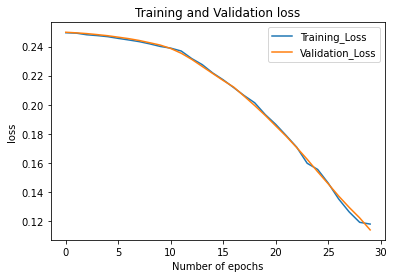

In [380]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

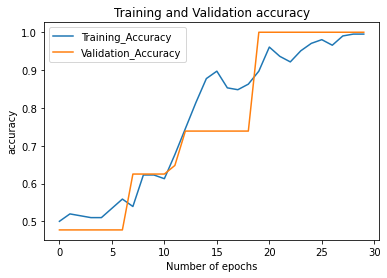

In [381]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [382]:
# display long string 
pd.options.display.max_colwidth=100
messages[:3]

,message,label
0,"Woy ngentot bayar gak, gw sebar foto2 lu",threat
1,oi jamet bayar gak lo skrg?!,threat
2,hati hati anda saya gak segan mencelakai anda,threat


In [406]:
predict_msg = ["woy anjing"]

In [407]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

In [408]:
predict_spam(predict_msg)


array([[0.60341]], dtype=float32)